In [86]:
import numpy as np
import math

import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker
import matplotlib.gridspec as gridspec

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from IPython.display import Image

from tqdm import tqdm
import os 


In [2]:
directory = '/n/home12/hongwei/HONGWEI/lagranto.ecmwf/run_3yr'
filename = '/traj_3yr.1'

In [3]:
file1 = open(directory+filename, 'r')
Lines = file1.readlines()

N_head = 5 # first 5 lines are head lines, not include data
N_column = 4

Nx = 36
Ny = 21
Nz = 5
N_parcel = 3780

if Nx*Ny*Nz!=N_parcel: print('ERROR: parcel number is wrong!')

Nt = int( (len(Lines)-4)/N_parcel - 1 ) # 2928

data = np.zeros((N_parcel, Nt, N_column))


In [4]:
count = 0

# Strips the newline character
for line in tqdm(Lines):
    count += 1
#     print("Line{}: {}".format(count, line.strip()))
    
    if count>=5:
        i = count-5
        i_parcel = math.floor( i / (Nt+1) ) # Nt time lines plue 1 empty line
        i_t = i%(Nt+1)
        
        if i_t!=0:
            a = line.split()

            if i_t==1:
                if float(a[0])!=0.0: print('ERROR: first time is not 0 !!!')
#             data[i_parcel,i_t-1,0] = float(a[0]) # time
            data[i_parcel,i_t-1,1] = float(a[1]) # lon
            data[i_parcel,i_t-1,2] = float(a[2]) # lat
            data[i_parcel,i_t-1,3] = float(a[3]) # lev
#             print(i_parcel, i_t-1, data[i_parcel,i_t-1,:])

100%|██████████| 33146824/33146824 [01:15<00:00, 438864.87it/s]


In [5]:
data2 = np.zeros((Nz,Ny,Nx,Nt,N_column))

for iy in tqdm(range(Ny)):
    for iz in range(Nz):
        for ix in range(Nx):
            i_parcel = iy*(Nz*Nx) + iz*Nx + ix
            data2[iz,iy,ix,:,:] = data[i_parcel,:,:]
#             print(i_parcel)

100%|██████████| 21/21 [00:00<00:00, 36.77it/s]


In [73]:
lifetime = np.zeros((Nz,Ny,Nx))

for iy in tqdm(range(Ny)):
    for iz in range(Nz):
        for ix in range(Nx):
            Num = sum(1 for i in data2[iz,iy,ix,:,3] if i<=120)
#             for i in data2[iz,iy,ix,:,:]:
#                 print(i)
#             print(Num)
            lifetime[iz,iy,ix] = Num*3/24 # hour to day

100%|██████████| 21/21 [00:14<00:00,  1.49it/s]


In [74]:
LON = np.zeros((Ny,Nx))
LAT = np.zeros((Ny,Nx))

for iy in tqdm(range(Ny)):
        for ix in range(Nx):
            LON[iy,ix] = data2[0,iy,ix,0,1]
            LAT[iy,ix] = data2[0,iy,ix,0,2]

100%|██████████| 21/21 [00:00<00:00, 24569.14it/s]


In [75]:
# Sort lat dimension from min to max [-20:20]
print(LAT[:,0])

index = np.argsort(LAT[:,0])

LAT[:,:] = LAT[index,:]
LON[:,:] = LON[index,:]
lifetime[:,:,:] = lifetime[:,index,:]
data2[:,:,:,:,:] = data2[:,index,:,:,:]

print(LAT[:,0])

[ 10.  -2.   6. -16. -12.  20.  -4.  16.  14. -20.   4.   2.   8. -14.
 -18.  18. -10.  -8.  -6.   0.  12.]
[-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.
   8.  10.  12.  14.  16.  18.  20.]


In [76]:
Pressure = [100, 70, 50, 40, 25] # hPa

Life_mean = np.mean(lifetime, axis=(1,2))
Life_std = np.std(lifetime, axis=(1,2))

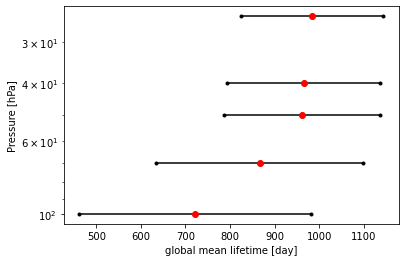

In [77]:

for i in range(len(Pressure)):
    Xs = [Life_mean[i]-Life_std[i], Life_mean[i]+Life_std[i]]
    Ys = [Pressure[i], Pressure[i]]
    plt.plot(Xs, Ys, 'k')

    
plt.plot(Life_mean, Pressure, 'ro')
plt.plot(Life_mean-Life_std, Pressure, 'k.')
plt.plot(Life_mean+Life_std, Pressure, 'k.')

plt.xlabel('global mean lifetime [day]')
plt.ylabel('Pressure [hPa]')

plt.yscale('log')
plt.gca().invert_yaxis()

In [78]:
Life_Q1 = np.zeros(5)
Life_Q2 = np.zeros(5)
Life_Q3 = np.zeros(5)

for i in range(len(Pressure)):
    Life_Q1[i] = np.percentile(lifetime[i,:,:].flatten(), 25)  # Q1
    Life_Q2[i] = np.percentile(lifetime[i,:,:].flatten(), 50)  # Q1
    Life_Q3[i] = np.percentile(lifetime[i,:,:].flatten(), 75)  # Q1

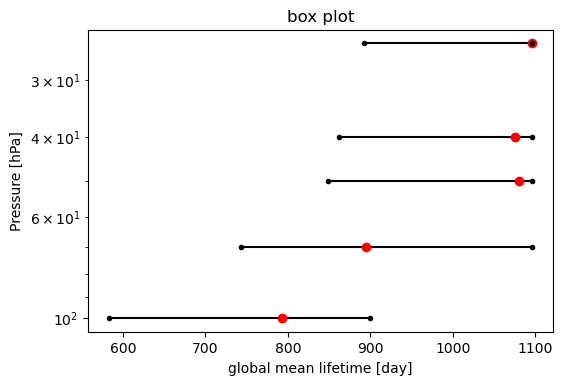

In [79]:
plt.figure(dpi=100)

for i in range(len(Pressure)):
    Xs = [Life_Q1[i], Life_Q3[i]]
    Ys = [Pressure[i], Pressure[i]]
    plt.plot(Xs, Ys, 'k')

    
plt.plot(Life_Q2, Pressure, 'ro')
plt.plot(Life_Q1, Pressure, 'k.')
plt.plot(Life_Q3, Pressure, 'k.')

plt.xlabel('global mean lifetime [day]')
plt.ylabel('Pressure [hPa]')
plt.title('box plot')

plt.yscale('log')
plt.gca().invert_yaxis()

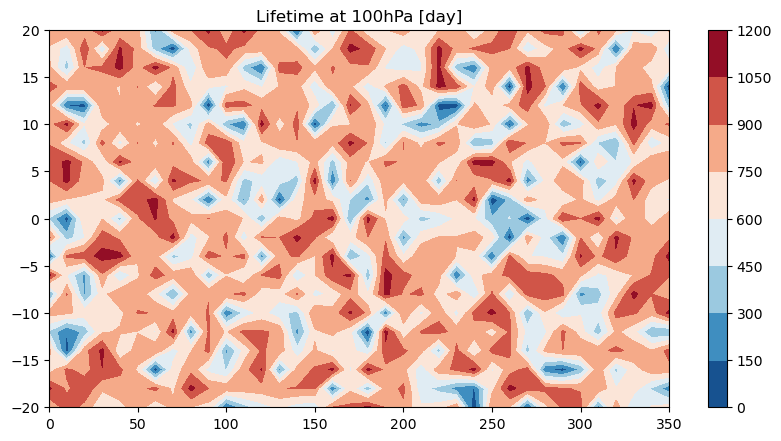

In [118]:
# contourf

plt.figure(figsize=(10,5), dpi=100)

X = LON
Y = LAT

Z = lifetime[0,:,:] # 100 hPa

plt.contourf(X, Y, Z, cmap='RdBu_r')
# plt.pcolormesh(X, Y, Z, cmap='RdBu')
plt.colorbar();

plt.title('Lifetime at 100hPa [day]');

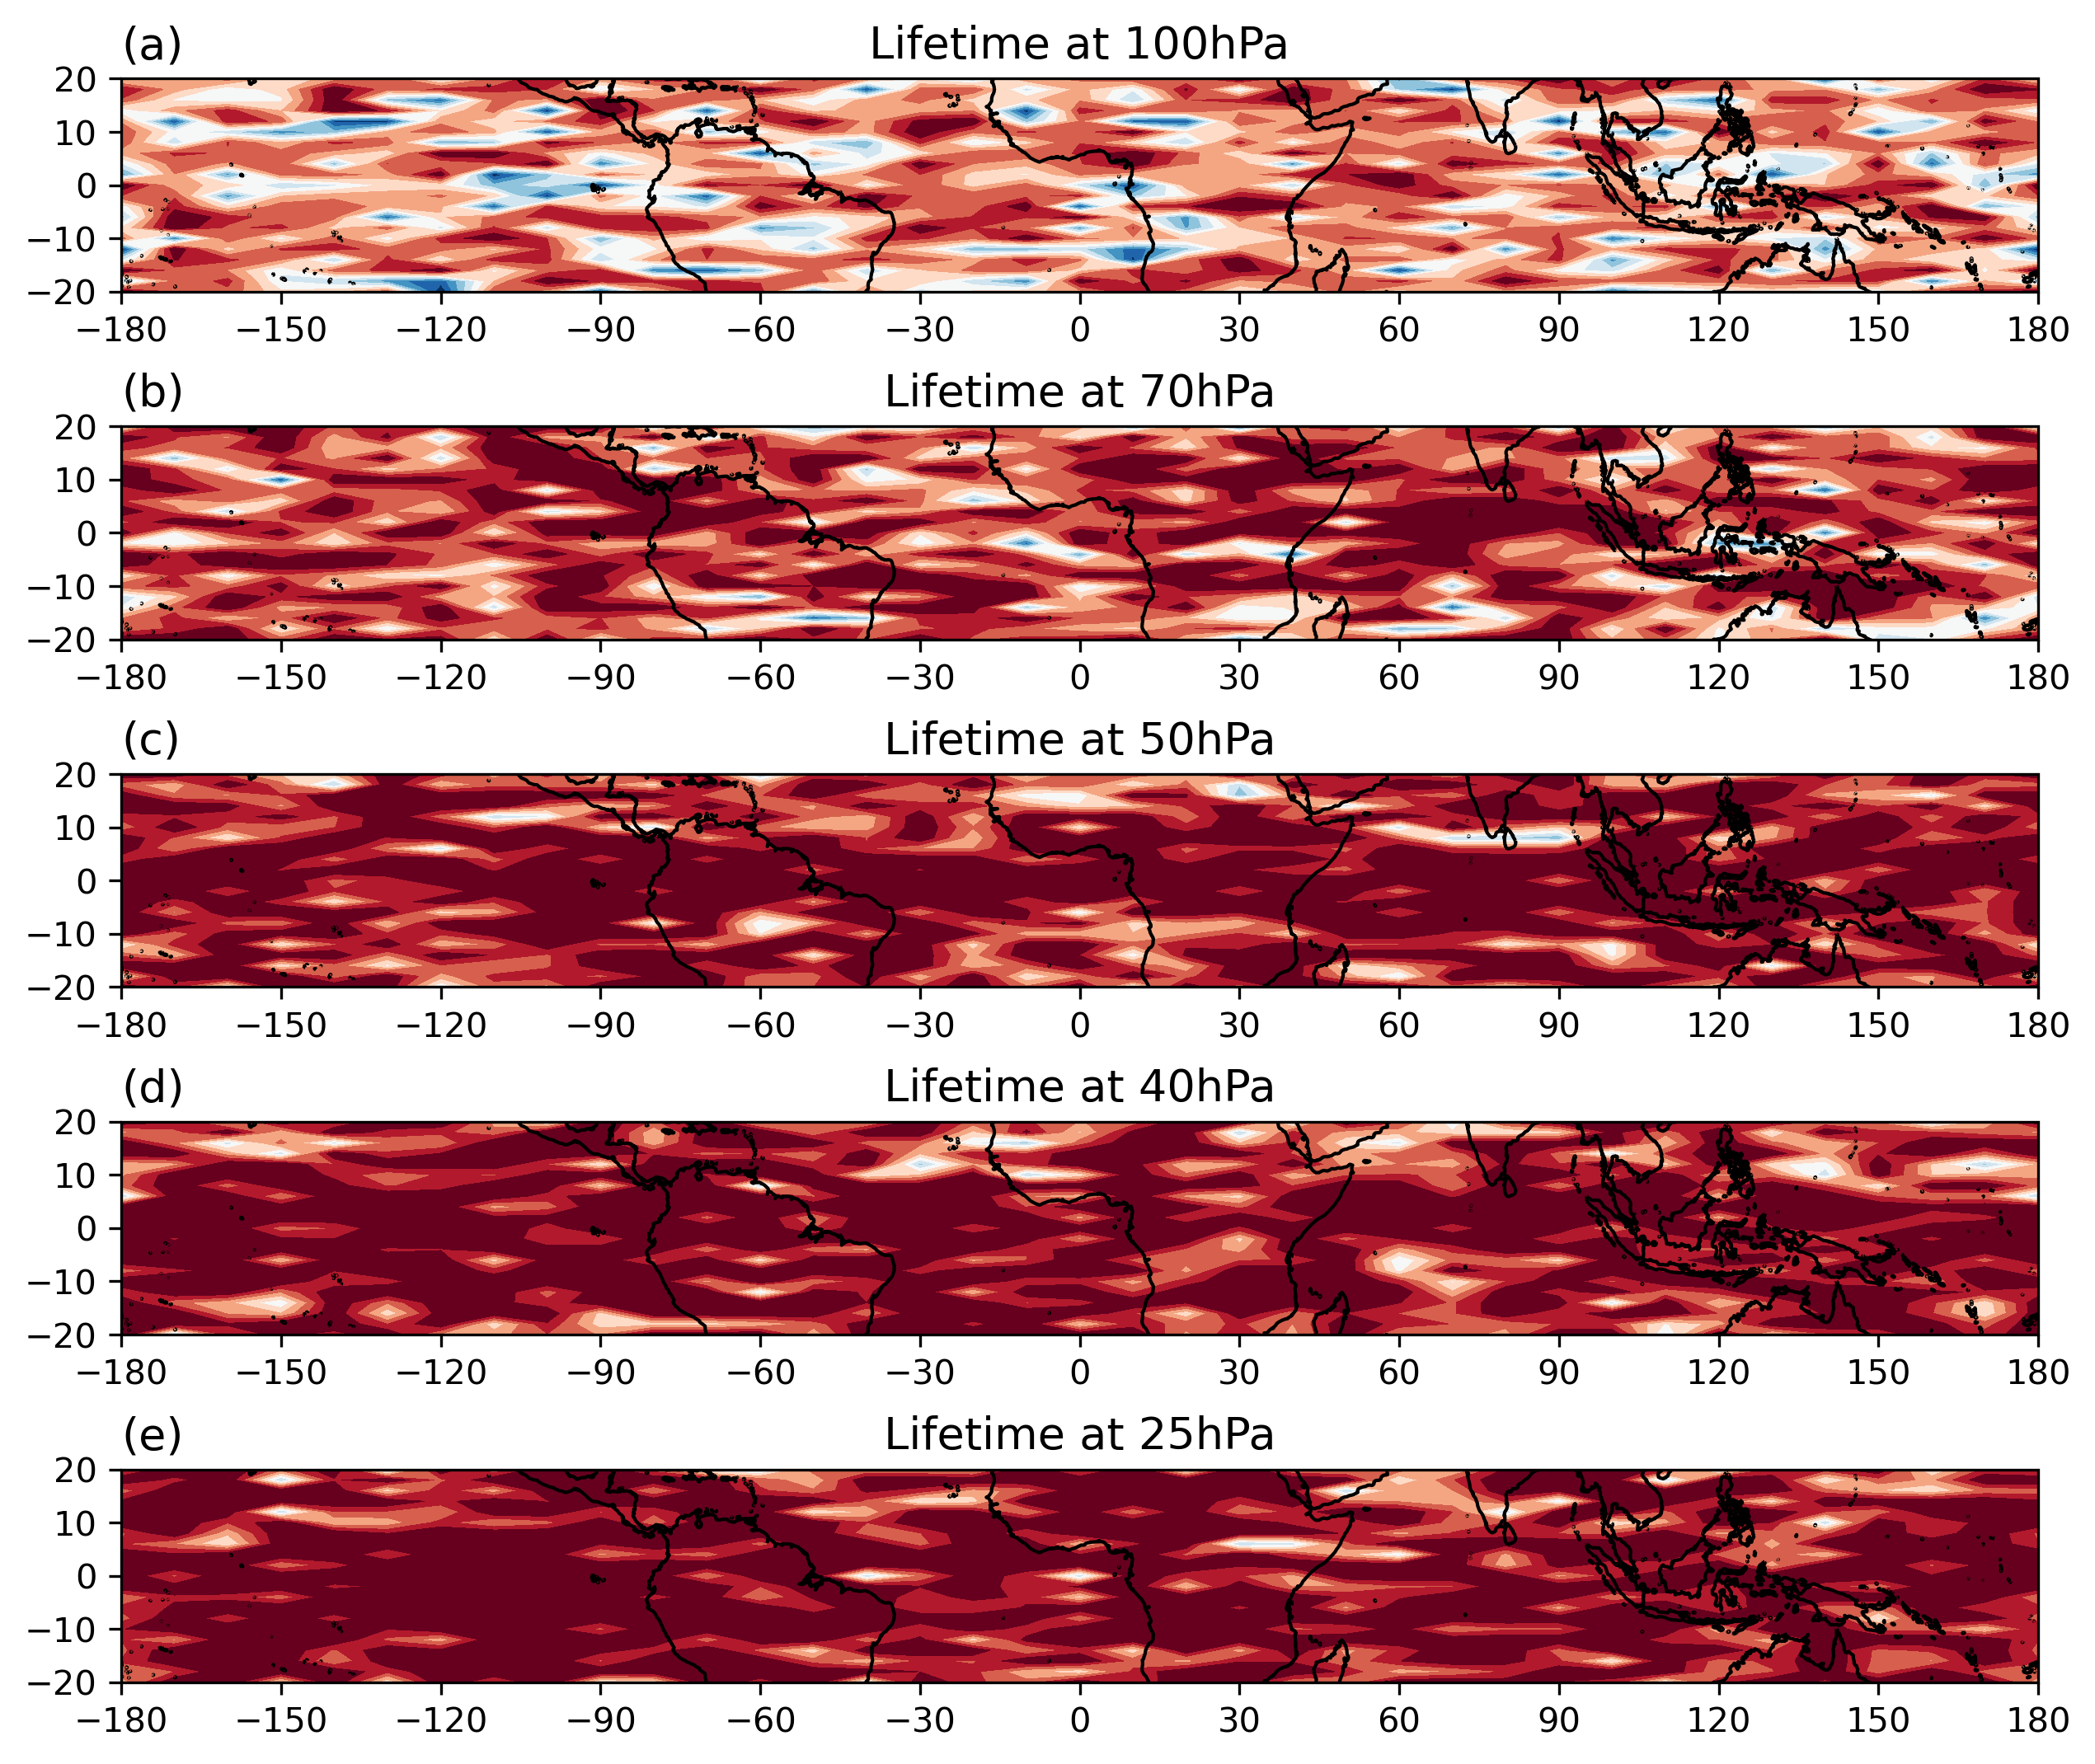

In [133]:
fig = plt.figure(figsize=(10,9), dpi=300);
# gs = gridspec.GridSpec(1, 11, figure=fig)
# plt.suptitle('Day: '+str(i+1), fontsize=16);

# ax1

# ax1 = plt.subplot(3,1,1)
projection=ccrs.PlateCarree()
# ax1 = fig.add_subplot(projection=ccrs.PlateCarree())
ax1 = plt.subplot(5, 1, 1, projection=ccrs.PlateCarree());
# ax1.set_global()
    
# ax1.gridlines(x_inline=True)    
ax1.set_xticks(np.linspace(-180, 180, 13), crs=projection)
ax1.set_yticks(np.linspace(-20, 20, 5), crs=projection)
# lon_formatter = LongitudeFormatter(zero_direction_label=True)
# lat_formatter = LatitudeFormatter()
# ax1.xaxis.set_major_formatter(lon_formatter)
# ax1.yaxis.set_major_formatter(lat_formatter)
#     z = ma.masked_where(LA_Zsum[i,:,:] <= 1e-10, LA_Zsum[i,:,:])

levels =  np.arange(0,1200,100)

norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

lat0 = LAT[:,0]
lon0 = LON[0,:]
data = lifetime[0,:,:]
cyclic_data = add_cyclic_point(data)
data, lon0_cyclic = add_cyclic_point(data, coord=lon0)
    
ax1_contours = ax1.contourf(lon0_cyclic, lat0, data, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("RdBu_r"), extend="max");
    
# cb1 = plt.colorbar(ax1_contours, ax=ax1, orientation="horizontal")
# cb1 = plt.colorbar(ax1_contours, ax=ax1)
# cb1.ax.tick_params(labelsize=11)
# cb1.set_label('[day]', fontsize=12)
    
ax1.coastlines();
ax1.set_title('Lifetime at 100hPa', fontsize=13);
ax1.set_title('(a)', fontsize=13, loc='left');

# ax2

ax2 = plt.subplot(5, 1, 2, projection=ccrs.PlateCarree());
    
ax2.set_xticks(np.linspace(-180, 180, 13), crs=projection)
ax2.set_yticks(np.linspace(-20, 20, 5), crs=projection)

levels =  np.arange(0,1200,100)

norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

lat0 = LAT[:,0]
lon0 = LON[0,:]
data = lifetime[1,:,:]
cyclic_data = add_cyclic_point(data)
data, lon0_cyclic = add_cyclic_point(data, coord=lon0)
    
ax2_contours = ax2.contourf(lon0_cyclic, lat0, data, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("RdBu_r"), extend="max");
    
# cb2 = plt.colorbar(ax2_contours, ax=ax2)
# cb2.ax.tick_params(labelsize=11)
# cb2.set_label('[day]', fontsize=12)
    
ax2.coastlines();
ax2.set_title('Lifetime at 70hPa', fontsize=13);
ax2.set_title('(b)', fontsize=13, loc='left');

# ax=3

ax3 = plt.subplot(5, 1, 3, projection=ccrs.PlateCarree());
    
ax3.set_xticks(np.linspace(-180, 180, 13), crs=projection)
ax3.set_yticks(np.linspace(-20, 20, 5), crs=projection)

levels =  np.arange(0,1200,100)

norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

lat0 = LAT[:,0]
lon0 = LON[0,:]
data = lifetime[2,:,:]
cyclic_data = add_cyclic_point(data)
data, lon0_cyclic = add_cyclic_point(data, coord=lon0)
    
ax3_contours = ax3.contourf(lon0_cyclic, lat0, data, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("RdBu_r"), extend="max");
    
# cb3 = plt.colorbar(ax3_contours, ax=ax3)
# cb3.ax.tick_params(labelsize=11)
# cb3.set_label('[day]', fontsize=12)
    
ax3.coastlines();
ax3.set_title('Lifetime at 50hPa', fontsize=13);
ax3.set_title('(c)', fontsize=13, loc='left');

# ax=4

ax4 = plt.subplot(5, 1, 4, projection=ccrs.PlateCarree());
    
ax4.set_xticks(np.linspace(-180, 180, 13), crs=projection)
ax4.set_yticks(np.linspace(-20, 20, 5), crs=projection)

levels =  np.arange(0,1200,100)

norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

lat0 = LAT[:,0]
lon0 = LON[0,:]
data = lifetime[3,:,:]
cyclic_data = add_cyclic_point(data)
data, lon0_cyclic = add_cyclic_point(data, coord=lon0)
    
ax4_contours = ax4.contourf(lon0_cyclic, lat0, data, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("RdBu_r"), extend="max");
    
# cb4 = plt.colorbar(ax4_contours, ax=ax4)
# cb4.ax.tick_params(labelsize=11)
# cb4.set_label('[day]', fontsize=12)
    
ax4.coastlines();
ax4.set_title('Lifetime at 40hPa', fontsize=13);
ax4.set_title('(d)', fontsize=13, loc='left');


# ax=5

ax5 = plt.subplot(5, 1, 5, projection=ccrs.PlateCarree());
    
ax5.set_xticks(np.linspace(-180, 180, 13), crs=projection)
ax5.set_yticks(np.linspace(-20, 20, 5), crs=projection)

levels =  np.arange(0,1200,100)

norm = colors.BoundaryNorm(boundaries=levels, ncolors=256)

lat0 = LAT[:,0]
lon0 = LON[0,:]
data = lifetime[4,:,:]
cyclic_data = add_cyclic_point(data)
data, lon0_cyclic = add_cyclic_point(data, coord=lon0)
    
ax5_contours = ax5.contourf(lon0_cyclic, lat0, data, levels=levels, norm=norm,\
                                transform=ccrs.PlateCarree(), cmap=get_cmap("RdBu_r"), extend="max");
    
# cb5 = plt.colorbar(ax5_contours, ax=ax5)
# cb5.ax.tick_params(labelsize=11)
# cb5.set_label('[day]', fontsize=12)
    
ax5.coastlines();
ax5.set_title('Lifetime at 25hPa', fontsize=13);
ax5.set_title('(e)', fontsize=13, loc='left');

In [81]:
X.shape, Y.shape, Z.shape

((21, 36), (21, 36), (21, 36))

In [ ]:
# a[0:4]:
# time, lon, lat, p

In [7]:
# plot

for i in tqdm(np.arange(0,30,1)):
    fig = plt.figure(figsize=(12,6), dpi=100)

    ax1 = fig.add_subplot(1,1,1, projection=crs.Robinson())
    ax1.set_global()
    ax1.add_feature(cfeature.COASTLINE, edgecolor="grey")
    ax1.add_feature(cfeature.BORDERS, edgecolor="grey")
    ax1.gridlines()

    xx=data[::36,i*8,1]
    yy=data[::36,i*8,2]
    
    ax1.scatter(x=xx, y=yy,
            color="red",
            s=1,
            alpha=0.5,
            transform=crs.PlateCarree()) ## Important

#     ax1.set_title(f'time: $(i*3) hour')


    plt.tight_layout()
    plt.savefig(str(i+1)+'_xy.png', transparent=False, facecolor='w', edgecolor='w');
    plt.close();
    plt.clf();
    plt.cla();
    
        
plt.close();

100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


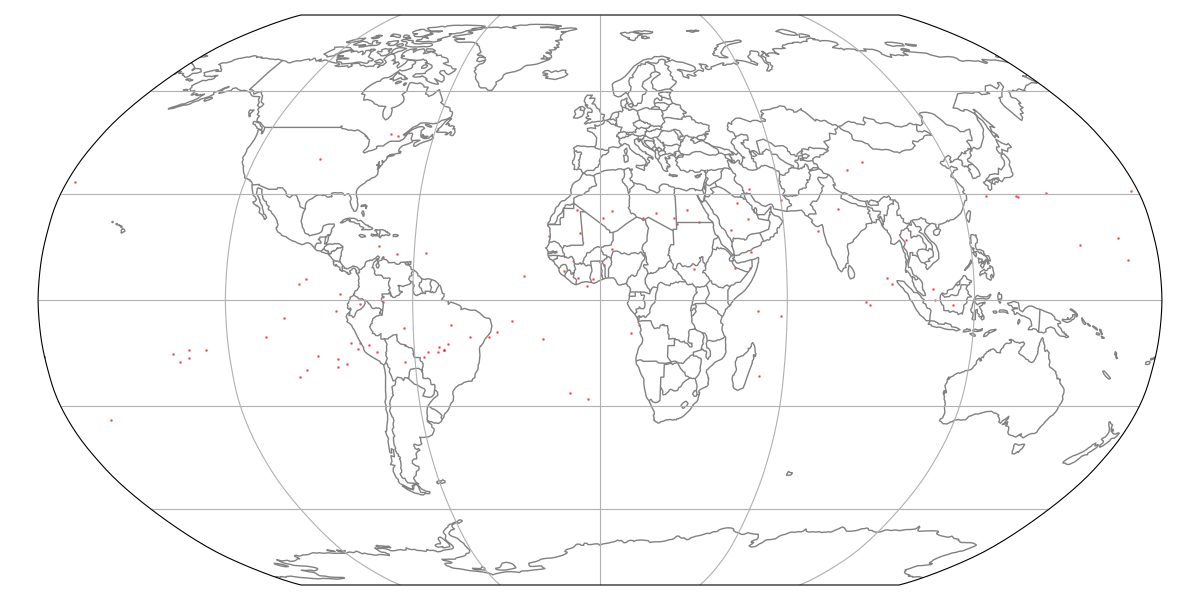

In [42]:

Image(filename=f'10_xy.png')

In [43]:
os.system('./png2gif2.sh')

0

In [17]:
N_days = 10

for i in tqdm(range( int(365*3/N_days) )):
    
    
    # (1)
    fig = plt.figure(figsize=(12,6), dpi=100)

    ax1 = fig.add_subplot(1,1,1)
    
    
    
    # 25 hpa    
    xx4=data2[4,:,:,i*8*N_days,2].flatten()
    yy4=data2[4,:,:,i*8*N_days,3].flatten()
    
    ax1.scatter(x=xx4[:], y=yy4[:],
            color="purple", label='25 hPa',
            s=1) ## Important
    
    ax1.plot((-90,90),(25,25),'purple',alpha=0.2)

    
    # 40 hpa
    xx3=data2[3,:,:,i*8*N_days,2].flatten()
    yy3=data2[3,:,:,i*8*N_days,3].flatten()
    
    ax1.scatter(x=xx3[:], y=yy3[:],
            color="cyan", label='40 hPa',
            s=1) ## Important
    
    ax1.plot((-90,90),(40,40),'cyan',alpha=0.2)
    
    
    # 50 hpa
    xx2=data2[2,:,:,i*8*N_days,2].flatten()
    yy2=data2[2,:,:,i*8*N_days,3].flatten()
    
    ax1.scatter(x=xx2[:], y=yy2[:],
            color="orange", label='50 hPa',
            s=1) ## Important
    
    ax1.plot((-90,90),(50,50),'orange',alpha=0.2)

    
    # 70 hpa    
    xx1=data2[1,:,:,i*8*N_days,2].flatten()
    yy1=data2[1,:,:,i*8*N_days,3].flatten()
    
    ax1.scatter(x=xx1[:], y=yy1[:],
            color="blue", label='70 hPa',
            s=1) ## Important

    ax1.plot((-90,90),(70,70),'blue',alpha=0.2)
        

    # 100 hpa
    xx0=data2[0,:,:,i*8*N_days,2].flatten()
    yy0=data2[0,:,:,i*8*N_days,3].flatten()
    
    ax1.scatter(x=xx0[:], y=yy0[:],
            color="red", label='100 hPa',
            s=1) ## Important
    ax1.plot((-90,90),(100,100),'red',alpha=0.2)
        
        
    
    ax1.set_xlim([-90,90])
    ax1.set_ylim([1, 1000])
    
    ax1.set_yscale('log')
    plt.gca().invert_yaxis()
    
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel('Pressure [hPa]')
    ax1.set_title('Day: ' + str(i*N_days))

    plt.legend()
    plt.tight_layout()
    plt.savefig(str(i+1)+'_yz.png', transparent=False, facecolor='w', edgecolor='w');
    plt.close();
    plt.clf();
    plt.cla();
    
        
plt.close();

100%|██████████| 109/109 [01:17<00:00,  1.40it/s]


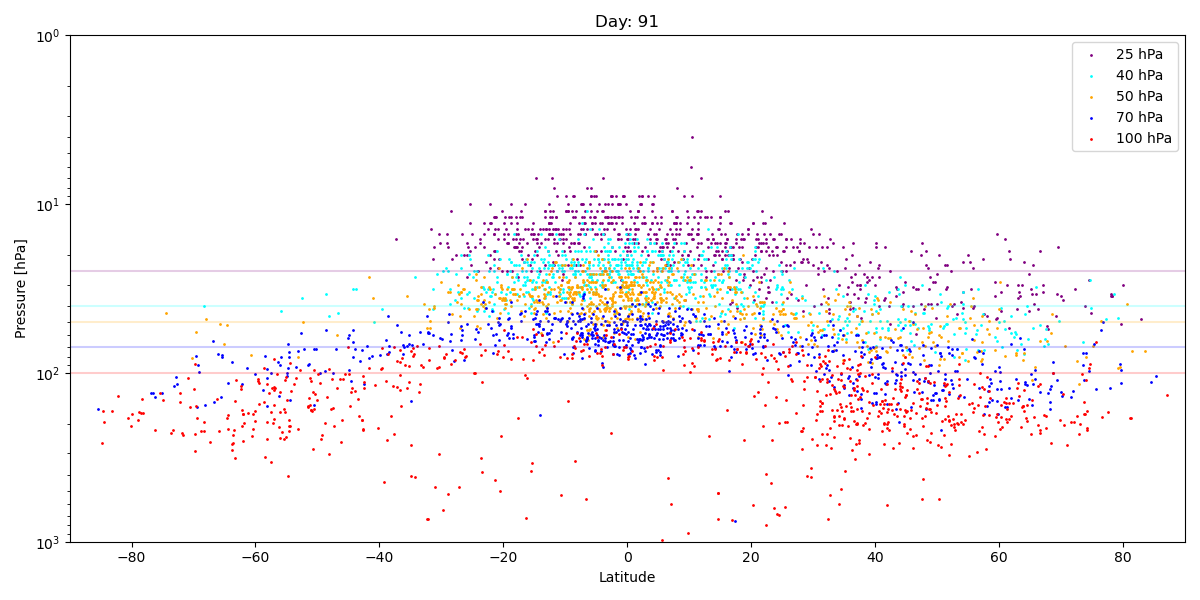

In [18]:
Image(filename=f'10_yz.png')

In [19]:
os.system('./png2gif2_yz.sh')

0